In [15]:
import sys
import os
sys.path.append(os.path.abspath("D:\\Python\\commodity_futures_price"))

import math

import numpy as np
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)

import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from model.savvy_sh import SavvySh

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
df_dict_cc1 = {}
valid_dates = pd.date_range(start="2011-01-01", end="2024-12-31", freq="B")
# Read each file in below folder
path = "../../data/raw/"
files = os.listdir(path)
for file in files:
    if file.endswith(".csv"):
        # Exclude LA, LB, JN, LL, LN, LT, LX, XB due to data correctness issue
        if file.startswith(("LA", "LB", "JN", "LL", "LN", "LT", "LX", "XB")):
            continue
        df = pd.read_csv(os.path.join(path, file), index_col=0, parse_dates=True)

        # Drop non-positive values in price and volatility
        non_positive_LA = df[(df[df.columns[0]] <= 0) | (df['Volatility'] <= 0)]
        if not non_positive_LA.empty:
            print(f"Non-positive values found in {file[:-4]}")
        df = df.drop(index=non_positive_LA.index)

        df_dict_cc1[file[:-4]] = df
        valid_dates = valid_dates.intersection(df.index)

for name, df in df_dict_cc1.items():
    df = df[df.index.isin(valid_dates)].loc["2011-12-30":"2024-05-31"]
    df_dict_cc1[name] = df

In [ ]:
df_dict_cc2 = {}
# Read each file in below folder
path = "../../data/investing.com/"
files = os.listdir(path)
for file in files:
    if file.endswith(".csv"):
        # Exclude LB due to data correctness issue
        if file.startswith(("LA", "LB", "JN", "LL", "LN", "LT", "LX", "XB")):
            continue
        df = pd.read_csv(os.path.join(path, file), index_col=0, parse_dates=True, thousands=",")
        df = df.iloc[:, 0:1].astype(float)
        if (df <= 0).any().any():
            print(f"Non-positive values found in {file[:-4]}")
        df = df[df > 0]

        # reverse the rows
        df = df.iloc[::-1]
        # take data during 2012-01-01 to 2024-06-01 only
        df = df.loc["2012-01-01":"2024-06-01"]

        # HG, HO
        if file.startswith(("HG", "HO")):
            df = df * 100
        # save the data
        df.to_csv(f"../../data/processed/cc2/{file[:-4]}.csv")

        df_dict_cc2[file[:-4]] = df

In [5]:
expiration_months = {
    "BO": [1, 3, 5, 7, 8, 9, 10, 12],   # Soybean Oil
    "CC": [3, 5, 7, 9, 12],             # Cocoa
    "CL": list(range(1, 13)),           # WTI Crude Oil (every month)
    "CO": list(range(1, 13)),           # Brent (every month)
    "CT": [3, 5, 7, 10, 12],            # Cotton
    "C_": [3, 5, 7, 9, 12],             # Corn
    "DA": list(range(1, 13)),           # Class III Milk
    "FC": [1, 3, 5, 8, 9, 11],          # Feeder Cattle
    "GC": [2, 4, 6, 8, 10, 12],         # Gold
    "HG": [3, 5, 7, 9, 12],             # Copper
    "HO": list(range(1, 13)),           # Heating Oil
    "JO": [1, 3, 5, 7, 9, 12],          # Orange Juice
    "KC": [3, 5, 7, 9, 12],             # Coffee
    "LC": [2, 4, 6, 8, 10, 12],         # Live Cattle
    "LH": [2, 4, 6, 8, 10, 12],         # Lean Hogs
    "NG": list(range(1, 13)),           # Nat Gas
    "O_": [3, 5, 7, 9, 12],             # Oats
    "PA": [3, 6, 9, 12],                # Palladium
    "PL": [1, 4, 7, 10],                # Platinum
    "QS": list(range(1, 13)),           # Other metals (London) every month
    "RR": [1, 3, 5, 7, 9, 11],          # Rough Rice
    "RS": [1, 3, 5, 7, 11],             # Canola
    "SB": [3, 5, 7, 10],                # Sugar
    "SI": [3, 5, 7, 9, 12],             # Silver
    "SM": [1, 3, 5, 7, 8, 9, 10, 12],   # Soybean Meal
    "S_": [1, 3, 5, 7, 8, 9, 11],       # Soybeans
    "W_": [3, 5, 7, 9, 12],             # Wheat
}

In [24]:
for name, df in df_dict_cc1.items():
    numerator = df.iloc[:, 0:1].shift(-1)[:-1]
    denominator = df_dict_cc2[name].iloc[:, 0:1]
    if name in ["CL", "CO", "DA", "HO", "NG", "QS"]:
        df["Return"] = np.append(numerator.values / denominator.iloc[:-1].values, np.nan)
        df["Log Return"] = np.append(np.log(numerator.values / denominator.iloc[:-1].values), np.nan)
    else:
        exp_month = expiration_months[name]
        for i in range(len(denominator) - 1):
            if denominator.index[i].month in exp_month:
                df.loc[df.index[i], "Return"] = numerator.values[i] / denominator.values[i]
                df.loc[df.index[i], "Log Return"] = np.log(numerator.values[i] / denominator.values[i])
            else:
                df.loc[df.index[i], "Return"] = denominator.values[i + 1] / denominator.values[i]
                df.loc[df.index[i], "Log Return"] = np.log(denominator.values[i + 1] / denominator.values[i])
    df.to_csv(f"../../data/processed/df_with_returns/{name}.csv")

### EDA

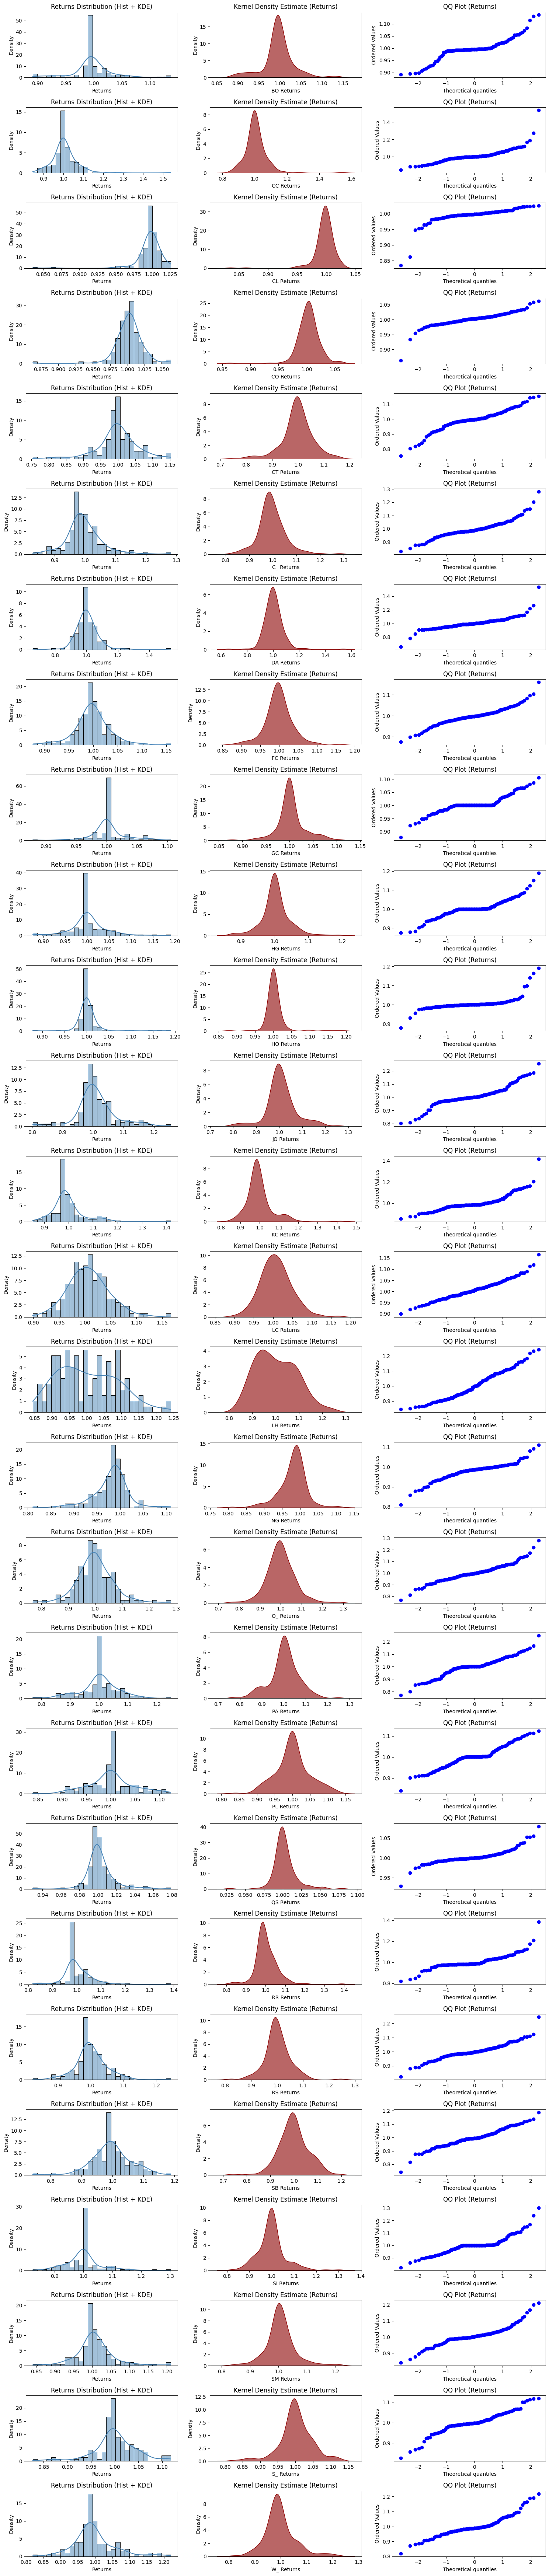

In [33]:
# Return
plt.figure(figsize=(15, 70))
for idx, df in enumerate(df_dict_cc1.values()):
    returns = df["Return"]
    plt.subplot(27, 3, idx * 3 + 1)
    sns.histplot(returns, bins=30, kde=True, color='steelblue', stat="density")
    plt.title('Returns Distribution (Hist + KDE)')
    plt.xlabel('Returns')
    plt.ylabel('Density')

    plt.subplot(27, 3, idx * 3 + 2)
    sns.kdeplot(returns, fill=True, color='darkred', alpha=0.6)
    plt.title('Kernel Density Estimate (Returns)')
    plt.xlabel(f'{list(df_dict_cc1.keys())[idx]} Returns')
    plt.ylabel('Density')

    plt.subplot(27, 3, idx * 3 + 3)
    stats.probplot(returns.values.flatten(), dist="norm", plot=plt)
    plt.title('QQ Plot (Returns)')

plt.tight_layout()
plt.show()

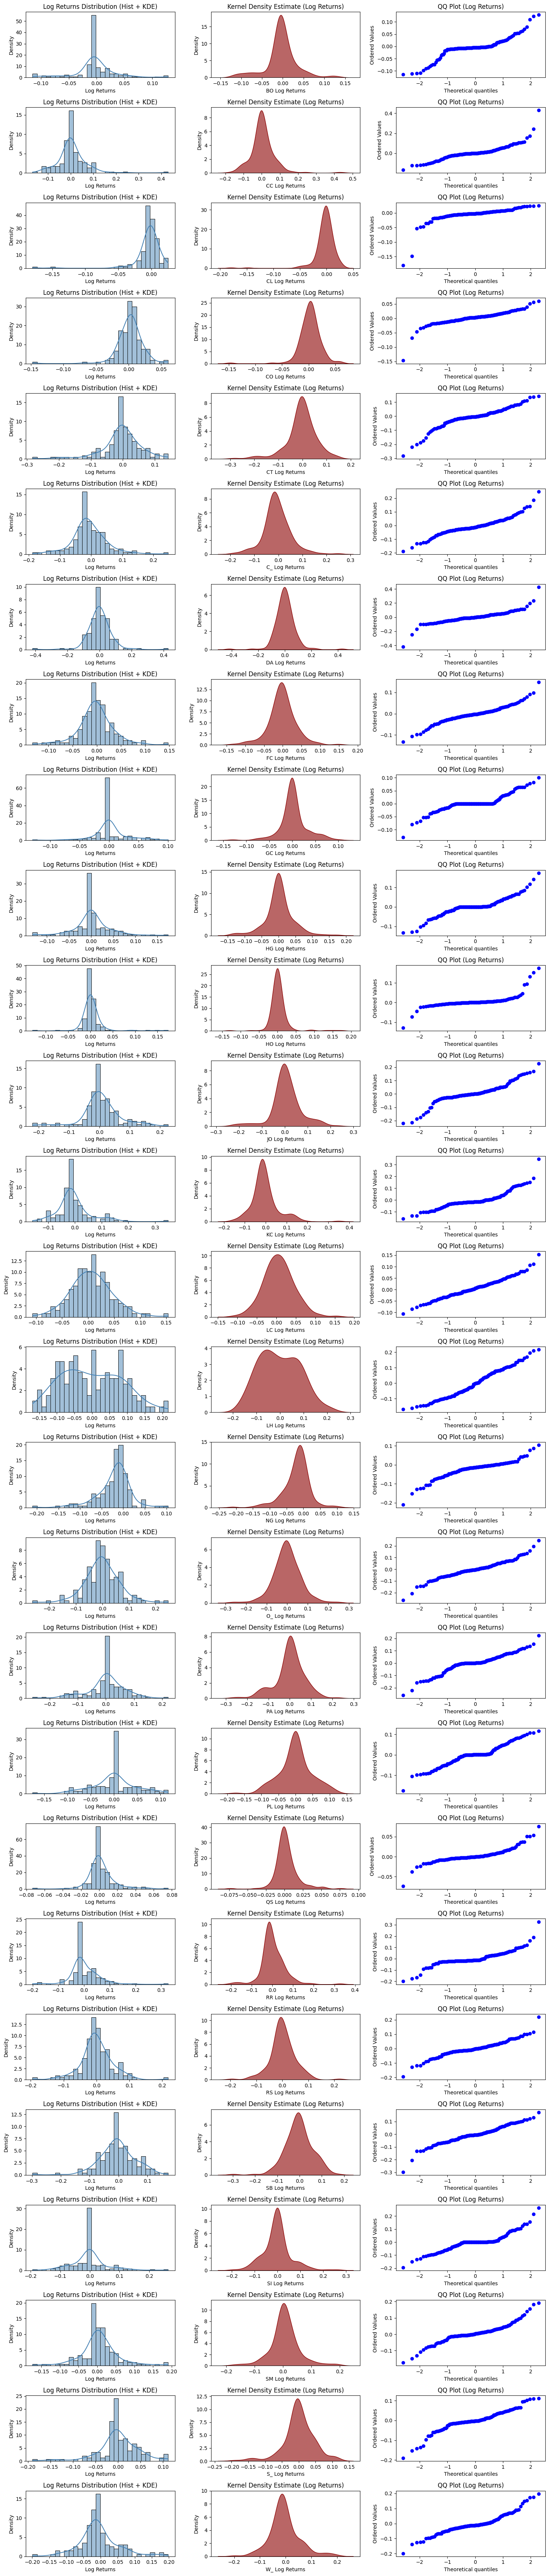

In [34]:
# Log Return
plt.figure(figsize=(15, 70))
for idx, df in enumerate(df_dict_cc1.values()):
    returns = df["Log Return"]
    plt.subplot(27, 3, idx * 3 + 1)
    sns.histplot(returns, bins=30, kde=True, color='steelblue', stat="density")
    plt.title('Log Returns Distribution (Hist + KDE)')
    plt.xlabel('Log Returns')
    plt.ylabel('Density')

    plt.subplot(27, 3, idx * 3 + 2)
    sns.kdeplot(returns, fill=True, color='darkred', alpha=0.6)
    plt.title('Kernel Density Estimate (Log Returns)')
    plt.xlabel(f'{list(df_dict_cc1.keys())[idx]} Log Returns')
    plt.ylabel('Density')

    plt.subplot(27, 3, idx * 3 + 3)
    stats.probplot(returns.values.flatten(), dist="norm", plot=plt)
    plt.title('QQ Plot (Log Returns)')

plt.tight_layout()
plt.show()

There exsists some skewness (both sides) for some commodity futures, and the most extreme one is CL. The returns of CL are mostly negative.

### Single Factor Sorting Test

In [35]:
# combine all df in df_dict_cc1 as one df
dfs = df_dict_cc1.copy()
for name, df in dfs.items():
    df["Commodity"] = name
    df = df.drop(df.columns[0], axis=1)
    dfs[name] = df
combined_df = pd.concat(dfs.values(), axis=0)

In [36]:
for factor in ["Momentum", "Basis", "Basis_Momentum", "Skewness", "Inflation_Beta", "Volatility", "Open_Interest", "Value"]:
    combined_df["quantile"] = combined_df.groupby(combined_df.index)[factor].transform(lambda x: pd.qcut(x, q=10, labels=False) + 1)
    port_ret = combined_df.groupby(["quantile", combined_df.index])["Return"].mean().unstack()
    ls_ret = port_ret.loc[10] - port_ret.loc[1]

    ann_mean = ls_ret.mean() * 12
    ann_vol = ls_ret.std() * np.sqrt(12)
    sharpe = ann_mean / ann_vol
    ic = combined_df.groupby(combined_df.index).apply(lambda g: stats.spearmanr(g[factor], g["Return"])[0])

    print(f"---Factor: {factor}")
    print(f"Annualized Mean: {ann_mean:.2f}")
    print(f"Annualized Volatility: {ann_vol:.2f}")
    print(f"Sharpe Ratio: {sharpe:.2f}")
    print(f"Information Coefficient: {ic.mean():.2f}")

Factor: Momentum
Annualized Mean: 0.18
Annualized Volatility: 0.18
Sharpe Ratio: 0.99
Information Coefficient: 0.12
Factor: Basis
Annualized Mean: -0.17
Annualized Volatility: 0.22
Sharpe Ratio: -0.78
Information Coefficient: -0.21
Factor: Basis_Momentum
Annualized Mean: 0.18
Annualized Volatility: 0.18
Sharpe Ratio: 0.99
Information Coefficient: 0.12
Factor: Skewness
Annualized Mean: 0.03
Annualized Volatility: 0.16
Sharpe Ratio: 0.17
Information Coefficient: -0.02
Factor: Inflation_Beta
Annualized Mean: 0.08
Annualized Volatility: 0.17
Sharpe Ratio: 0.46
Information Coefficient: 0.05
Factor: Volatility
Annualized Mean: -0.08
Annualized Volatility: 0.16
Sharpe Ratio: -0.49
Information Coefficient: -0.08
Factor: Open_Interest
Annualized Mean: 0.02
Annualized Volatility: 0.14
Sharpe Ratio: 0.17
Information Coefficient: 0.02
Factor: Value
Annualized Mean: -0.10
Annualized Volatility: 0.19
Sharpe Ratio: -0.52
Information Coefficient: -0.10


Base on above results:
- Momentum leads to a high sharpe ratio, an acceptable IC.  
- Momentum and Basis_Momentum might only need one.  
- Basis shows a reverse effect, which means the coefficient should be negative.  
- Inflation_Beta has a moderate results, could be considered for a moment.  
- Skeness, Volatility, Open_Interest, Value might not be effective.  